# Exercise 5

## 1. Constructing the matrix

In [151]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import lsqr
from typing import Optional, List

In [133]:
def create_C(M: int) -> np.ndarray:
    D = M ** 2
    b = (M / 2)
    b_lower = -b + 0.5
    b_upper = b + 0.5

    C = np.mgrid[b_lower:b_upper, b_lower:b_upper]
    C = np.column_stack((C[1].flatten(), np.flip(C[0].flatten())))
    C = C.T

    assert C.shape == (2, D)

    return C

In [134]:
def create_unit_vector(alpha: float) -> np.ndarray:
    return np.array([np.cos(alpha), np.sin(alpha)])

In [142]:
def construct_X(M: int, alphas: np.ndarray | List[float], Np: Optional[int] = None) -> coo_matrix:
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
    assert Np is not None

    alphas = np.radians(alphas)

    D = M ** 2
    No = len(alphas)
    N = No * Np
    beta = np.arange(D)
    j = np.concatenate((beta, beta))

    C = create_C(M)

    s_0 = (Np / 2) - 0.5

    i_s = []
    j_s = []
    x_s = []

    for alpha_i, alpha in enumerate(alphas):
        n = create_unit_vector(alpha)
        p = n.T @ C + s_0

        y_lower = np.floor(p)
        y_higher = y_lower + 1

        y_lower_dist = p - y_lower
        y_higher_dist = 1 - y_lower_dist

        y_lower_weight = 1 - y_lower_dist
        y_higher_weight = 1 - y_higher_dist

        i = np.concatenate((y_lower, y_higher))
        to_remove = np.logical_or(i < 0, i >= Np)
        # rp = np.repeat(np.arange(alpha_i, alpha_i + 1), D) * Np
        # i += np.concatenate((rp, rp))
        i += Np * alpha_i

        x = np.concatenate((y_lower_weight, y_higher_weight))

        # to_remove = np.unique(np.concatenate(np.where(x == 0)[0], to_remove))

        # j = np.concatenate((beta, beta))

        i, x, j = np.delete(i, to_remove), np.delete(x, to_remove), np.delete(j, to_remove)

        i_s.append(i)
        x_s.append(x)
        j_s.append(j)

    i = np.concatenate(i_s)
    j = np.concatenate(j_s)
    x = np.concatenate(x_s)

    X = coo_matrix((x, (i, j)), shape=(N, D), dtype=np.float32)
    return X


In [143]:
def construct_X_vectorized(M: int, alphas: np.ndarray | List[float], Np: Optional[int] = None) -> coo_matrix:
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
    assert Np is not None

    alphas = np.radians(alphas)

    D = M ** 2
    No = len(alphas)
    N = No * Np
    beta = np.arange(D)
    j = np.tile(np.concatenate((beta, beta)), len(alphas)).reshape((len(alphas), D * 2))

    C = create_C(M)

    assert C.shape == (2, D)

    s_0 = (Np / 2) - 0.5

    n = create_unit_vector(alphas)
    p = n.T @ C + s_0

    y_lower = np.floor(p)
    y_higher = y_lower + 1

    y_lower_dist = p - y_lower
    y_higher_dist = 1 - y_lower_dist

    y_lower_weight = 1 - y_lower_dist
    y_higher_weight = 1 - y_higher_dist

    i = np.concatenate((y_lower, y_higher), axis=1)
    to_remove = np.logical_or(i < 0, i >= Np)
    rp = np.repeat(np.arange(len(alphas)), D * 2) * Np
    i += rp.reshape((len(alphas), D * 2))

    x = np.concatenate((y_lower_weight, y_higher_weight), axis=1)

    i, x, j, to_remove = i.flatten(), x.flatten(), j.flatten(), to_remove.flatten()
    i, x, j = np.delete(i, to_remove), np.delete(x, to_remove), np.delete(j, to_remove)

    X = coo_matrix((x, (i, j)), shape=(N, D), dtype=np.float32)
    return X

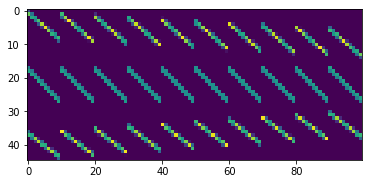

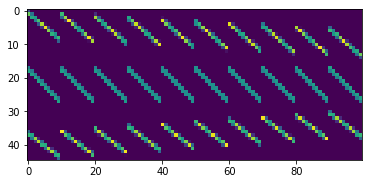

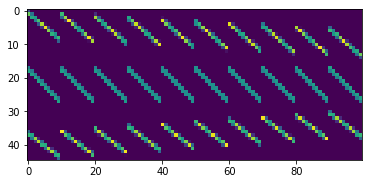

In [139]:
X_examp = np.load('tomography/X_example.npy')
plt.imshow(X_examp)
plt.show()

M = 10
alphas = np.array([-33, 1, 42])
Np = 15

X = construct_X_vectorized(M, alphas, Np)
X_dense = X.todense()
plt.imshow(X_dense)
plt.show()

assert np.allclose(X_examp, X_dense)

X = construct_X(M, alphas, Np)
X = X.todense()
plt.imshow(X_dense)
plt.show()

assert np.allclose(X_examp, X_dense)

In [145]:
print('Vectorized performance test')
% timeit construct_X_vectorized(10, [-33, 1, 42], 15)

print('Unvectorized performance test')
% timeit construct_X(10, [-33, 1, 42], 15)

Vectorized performance test
496 µs ± 73.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Unvectorized performance test
686 µs ± 114 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [146]:
print('Vectorized performance test')
% timeit construct_X_vectorized(195, np.linspace(0, 2 * np.pi, 179, False), 275)

print('Unvectorized performance test')
% timeit construct_X(195, np.linspace(0, 2 * np.pi, 179, False), 275)

Vectorized performance test
1.56 s ± 439 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Unvectorized performance test
1.56 s ± 264 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 2 Recovering the image

Loading the predifend data

In [148]:
alphas = np.load('tomography/alphas_77.npy')
y = np.load('tomography/y_77.npy')

print(alphas.shape)
print(y.shape)

(90,)
(9810,)


Constructing the X

In [154]:
M = 77
Np = 109

X = construct_X_vectorized(M, alphas, Np)

print(X.shape)

(9810, 5929)


Calculating the sparsity

In [155]:
non_zero_values = len(X.data)
total_size = np.prod(X.shape)
sparsity = non_zero_values / total_size

print(f'Non zero values: {non_zero_values}')
print(f'Sparsity: {sparsity}')

Non zero values: 1067220
Sparsity: 0.01834862385321101


Solving the least squares problem

(5929,)


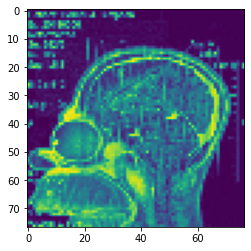

In [162]:
tolerance = 1e-08
beta, _, _, _, _, _, _, _, _, _ = lsqr(X, y, atol=tolerance, btol=tolerance)

assert len(beta) == M ** 2
print(beta.shape)

beta_image = beta.reshape((M, M))

plt.imshow(beta_image)
plt.show()

What causes the headache? (Loading a higher resolution image)

(179,)
(49225,)
(49225, 38025)
Non zero values: 13612930
Sparsity: 0.007272716587714439
(38025,)


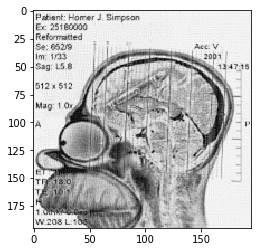

In [166]:
alphas = np.load('tomography/alphas_195.npy')
y = np.load('tomography/y_195.npy')

print(alphas.shape)
print(y.shape)

M = 195
Np = 275

X = construct_X_vectorized(M, alphas, Np)

print(X.shape)

non_zero_values = len(X.data)
total_size = np.prod(X.shape)
sparsity = non_zero_values / total_size

print(f'Non zero values: {non_zero_values}')
print(f'Sparsity: {sparsity}')

tolerance = 1e-05
beta, _, _, _, _, _, _, _, _, _ = lsqr(X, y, atol=tolerance, btol=tolerance)

assert len(beta) == M ** 2
print(beta.shape)

beta_image = beta.reshape((M, M))

plt.imshow(beta_image, cmap='Greys',  interpolation='nearest')
plt.show()

The reason for the headache is a crayon
